This is a Laplace equation on a disk shaped domain with a Dirichlet and a periodic boundary condition, solved with a PINN model using the DeepXDE library.

<br>
\begin{equation}
r\frac{\partial y}{\partial r} + r^2\frac{\partial y}{\partial r^2} + \frac{\partial y}{\partial θ^2} = 0 \hspace{1cm} r∈[0,1], θ∈[0,2π]
\end{equation}

<br>

\begin{equation}
y(1,θ)=cos(θ)
\end{equation}

<br>

\begin{equation}
y(r,θ+2π)=y(r,θ)
\end{equation}

Test losses after 5000 epochs are approximately:

*In accordance to y output:* **5.30e-07**

*In accordance to initial conditions:* **5.35e-07**

*In accordance to the known solution:* **6.95e-04**

In [ ]:
# Import libraries

!pip install deepxde
import deepxde as dde
import numpy as np

     |████████████████████████████████| 121 kB 4.8 MB/s 
     |████████████████████████████████| 100 kB 7.4 MB/s 


Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
# Define computational geometry

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 2 * np.pi])

In [ ]:
# Define differencial equation

def pde(x, y):
  dy_r = dde.grad.jacobian(y, x, i=0, j=0)
  dy_rr = dde.grad.hessian(y, x, i=0, j=0)
  dy_thetatheta = dde.grad.hessian(y, x, i=1, j=1)
  return x[:, 0:1] * dy_r + x[:, 0:1] ** 2 * dy_rr + dy_thetatheta

In [ ]:
# Define boundary conditions

def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)    

bc_rad = dde.icbc.DirichletBC(geom, lambda x: np.cos(x[:, 1:2]), boundary)

In [ ]:
# Define known solution

def solution(x):
    r, theta = x[:, 0:1], x[:, 1:]
    return r * np.cos(theta)

In [ ]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, pde, bc_rad, num_domain=2540, num_boundary=80, solution=solution)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+84=84. 
  total_n_samples))


In [ ]:
# Create the neural network

net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

In [ ]:
# Apply a feature transform to the neural network

def feature_transform(x):
    return tf.concat(
        [x[:, 0:1] * tf.sin(x[:, 1:2]), x[:, 0:1] * tf.cos(x[:, 1:2])], axis=1
    )

net.apply_feature_transform(feature_transform)

In [ ]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.086673 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.810091 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [5.23e-02, 1.75e-01]    [5.23e-02, 1.75e-01]    [5.63e-01]    
1000      [2.38e-05, 4.91e-06]    [2.38e-05, 4.91e-06]    [4.71e-03]    
2000      [4.68e-06, 1.85e-06]    [4.68e-06, 1.85e-06]    [1.96e-03]    
3000      [1.17e-06, 1.02e-06]    [1.17e-06, 1.02e-06]    [9.45e-04]    
4000      [6.72e-07, 7.05e-07]    [6.72e-07, 7.05e-07]    [7.61e-04]    
5000      [5.30e-07, 5.35e-07]    [5.30e-07, 5.35e-07]    [6.95e-04]    

Best model at step 5000:
  train loss: 1.06e-06
  test loss: 1.06e-06
  test metric: [6.95e-04]

'train' took 63.697260 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


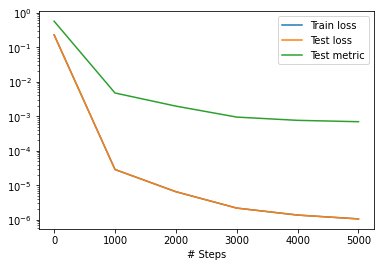

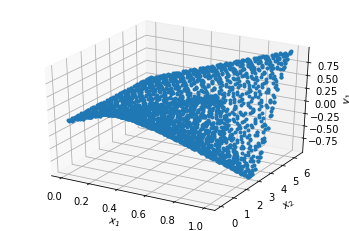

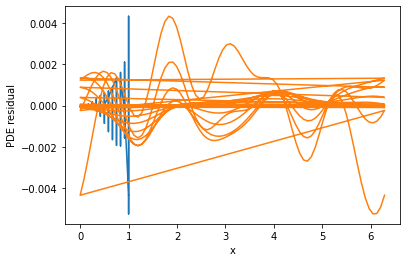

In [ ]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()